In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp

import quflow as qf
from cupyx.profiler import benchmark

2023-06-29 19:17:14.772664: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
qf.gpu.gpu_core.print_info()

CuPy version: 12.0.0
Device 0: b'NVIDIA GeForce GTX 1070':
	multiprocessor count: 15


Shown below is the execution time for different matrix size $N$ for both GPU and CPU, aswell as the respective speedup. The variables `time = 3.0`, `inner_time = 0.5` and
`qstepsize = 0.2` are fixed.

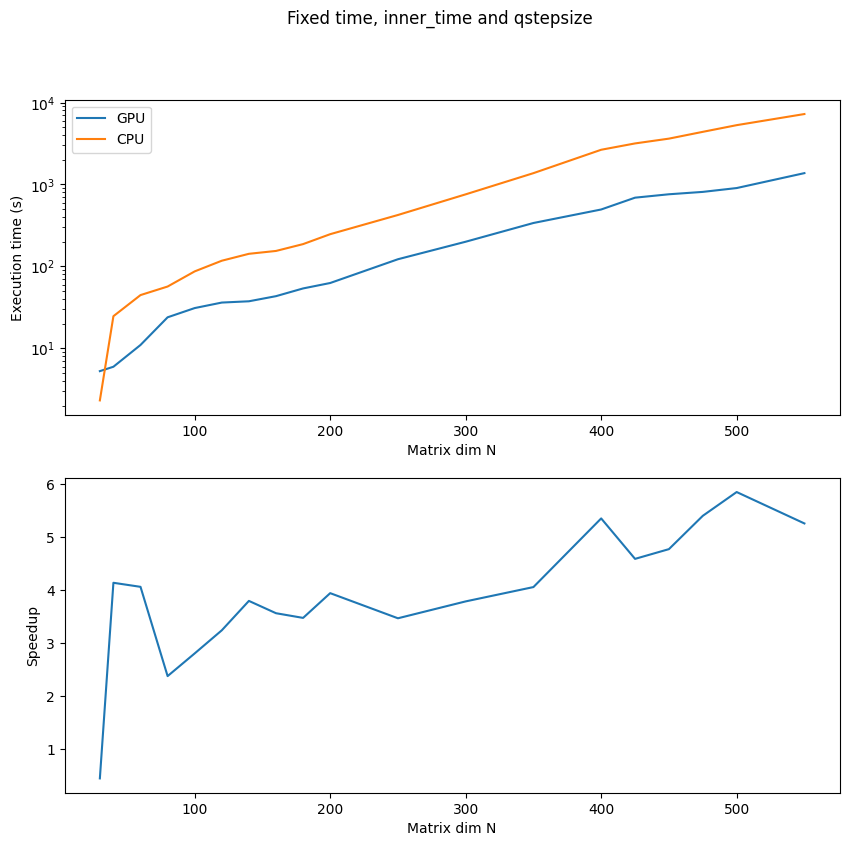

In [2]:
with open("speed_test2.json","r") as f:
    speed_data = json.load(f)



timings = np.array(speed_data["timings"])
n_samples = np.array(speed_data["n_samples"])

speedup = timings[1,:]/timings[0,:]

fig, ax = plt.subplots(2,1,figsize = (10,9))

fig.suptitle('Fixed time, inner_time and qstepsize')
# Execution time plot
ax[0].plot(n_samples,timings.T,label=["GPU","CPU"])

ax[0].set_yscale("log")
#ax[0].set_xscale("log")

ax[0].set_ylabel("Execution time (s)")
ax[0].set_xlabel("Matrix dim N")
ax[0].legend()

# Speedup plot

ax[1].plot(n_samples,speedup)

#ax[1].set_yscale("log")
#ax[1].set_xscale("log")

ax[1].set_ylabel("Speedup")
ax[1].set_xlabel("Matrix dim N")
#ax[1].legend()

plt.savefig("gpu_cpu_timings")

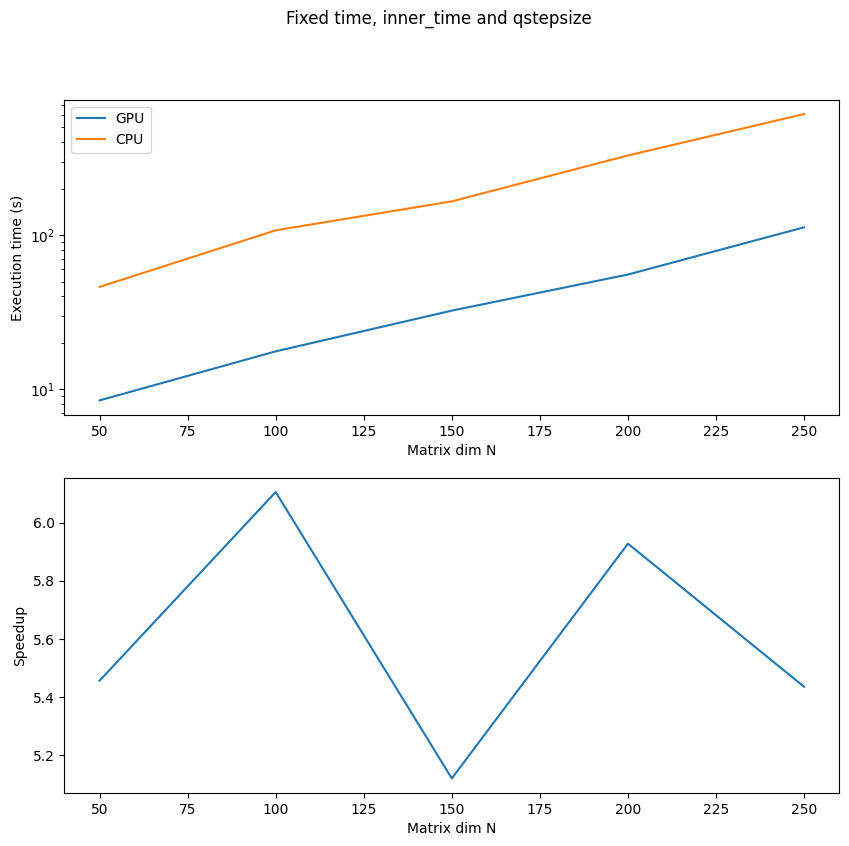

In [4]:
with open("speed_test_gpu.json","r") as f:
    speed_data = json.load(f)


timings = np.array(speed_data["timings"])
n_samples = np.array(speed_data["n_samples"])

speedup = timings[1,:]/timings[0,:]

fig, ax = plt.subplots(2,1,figsize = (10,9))

fig.suptitle('Fixed time, inner_time and qstepsize')
# Execution time plot
ax[0].plot(n_samples,timings.T,label=["GPU","CPU"])

ax[0].set_yscale("log")
#ax[0].set_xscale("log")

ax[0].set_ylabel("Execution time (s)")
ax[0].set_xlabel("Matrix dim N")
ax[0].legend()

# Speedup plot

ax[1].plot(n_samples,speedup)

#ax[1].set_yscale("log")
#ax[1].set_xscale("log")

ax[1].set_ylabel("Speedup")
ax[1].set_xlabel("Matrix dim N")
#ax[1].legend()

plt.savefig("gpu_cpu_timings")

In [3]:
def get_random_mat_cp(N=5,seed=None):
    if seed != None:
        cp.random.seed(seed)

    W = cp.random.randn(N, N) + 1j*cp.random.randn(N, N)
    W -= W.conj().T
    W -= cp.eye(N)*cp.trace(W)/N
    return W

def get_random_mat_np(N=5,seed=None):
    if seed != None:
        np.random.seed(seed)

    W = np.random.randn(N, N) + 1j*np.random.randn(N, N)
    W -= W.conj().T
    W -= np.eye(N)*np.trace(W)/N
    return W

def mult(A,B,C):
    cp.matmul(A,B,out=C)

Self made kernel with interleaved memory and caching underway:


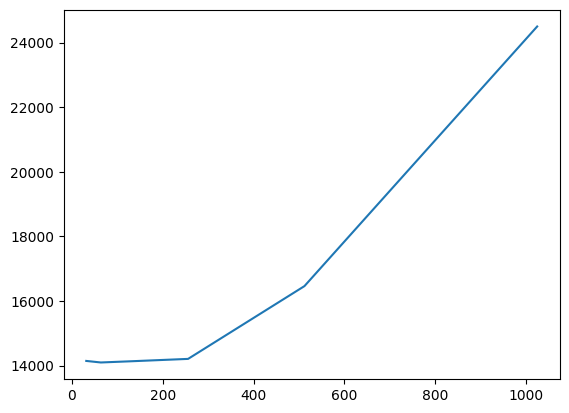

In [4]:
# ------- Testing block size for skew-herm cuThomas --------- #

N = 4096 # Size of matrices <---- Needs 
#N = 2048 # Size of matrix
n_repeat = 1000

# Cupy arrays
W0_cp = get_random_mat_cp(N)

P0_c = cp.zeros_like(W0_cp)
ham_c = qf.gpu.gpu_core.solve_poisson_interleaved_cp(N)


block_size_samples = np.array([32,64,128,256,512,1024])
block_size_timings = np.zeros_like(block_size_samples)

print("Self made kernel with interleaved memory and caching underway:")
for (i,b_size) in enumerate(block_size_samples):
    block_size_timings[i] = benchmark(ham_c.solve_poisson,(W0_cp,P0_c,b_size),n_repeat=n_repeat).gpu_times[0].mean()*1e6


plt.figure()
plt.plot(block_size_samples,block_size_timings)
plt.show()


[[15401.90866566]
 [15022.7273531 ]
 [35319.86265564]]


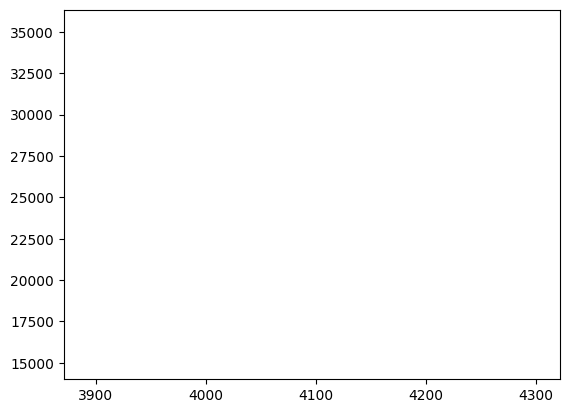

In [4]:
# ----------- comparing the different tridiagonal solvers ------- #

N_samples = np.array([4096]) # Size of matrices <---- Needs 
#N = 2048 # Size of matrix
n_repeat = 1000

timings = np.zeros((3,len(N_samples)))

# Cupy arrays

for (i,N) in enumerate(N_samples):
    W0_cp = get_random_mat_cp(N)


    P0_lm = cp.zeros_like(W0_cp)
    ham_lm = qf.gpu.gpu_core.solve_poisson_interleaved_lessmemory_cp(N)
    timings[0,i] = benchmark(ham_lm.solve_poisson,(W0_cp,P0_lm),n_repeat=n_repeat).gpu_times[0].mean()*1e6
    del ham_lm
    del P0_lm

    P0_c = cp.zeros_like(W0_cp)
    ham_c = qf.gpu.gpu_core.solve_poisson_interleaved_cp(N)
    timings[1,i] = benchmark(ham_c.solve_poisson,(W0_cp,P0_c),n_repeat=n_repeat).gpu_times[0].mean()*1e6
    del ham_c
    del P0_c

    P0_tf = cp.zeros_like(W0_cp)
    ham_tf = qf.gpu.gpu_tf.solve_poisson_cp(N)
    timings[2,i] = benchmark(ham_tf.solve_poisson,(W0_cp,P0_tf),n_repeat=n_repeat).gpu_times[0].mean()*1e6
    del ham_tf
    del P0_tf

    del W0_cp

print(timings)

plt.figure()
plt.plot(N_samples,timings[0], label ="Interleaved less mem" )
plt.plot(N_samples,timings[1], label ="Interleaved" )
plt.plot(N_samples,timings[2], label ="Tf" )
plt.show()


[   1352    1584    6182   47097  363220 2967772]


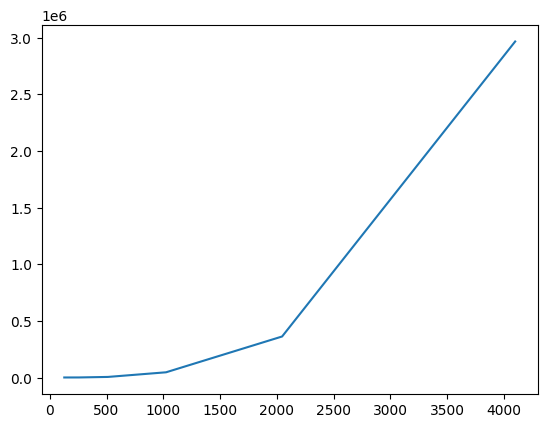

In [6]:
# ----------- matmul speed test ------- #

N_samples = np.array([128,256,512,1024,2046,4098])
n_repeat = 100

timings = np.zeros_like(N_samples)

for (i,N) in enumerate(N_samples):
    A = get_random_mat_cp(N,1)
    B = get_random_mat_cp(N,2)
    C = cp.empty_like(A)

    timings[i] = benchmark(mult,(A,B,C),n_repeat=n_repeat).gpu_times[0].mean()*1e6
    
    del A
    del B
    del C

print(timings)

plt.figure()
plt.plot(N_samples,timings)
plt.show()



In [8]:
print(2967772/25000)

118.71088


In [4]:
from scipy.linalg import eigh_tridiagonal

N = 4
basis_break_indices = np.hstack((0, (np.arange(N, 0, -1)**2).cumsum()))
basis = np.zeros(basis_break_indices[-1], dtype=float)

# Compute direct laplacian
lap = qf.laplacian.direct.compute_direct_laplacian(N, bc=False)

for m in range(N):
    bind0 = basis_break_indices[m]
    bind1 = basis_break_indices[m+1]

    # Compute eigen decomposition
    n = N - m
    start_ind = N*(N+1)//2 - n*(n+1)//2
    end_ind = start_ind + n
    v2, w2 = eigh_tridiagonal(lap[1, start_ind:end_ind], lap[0, start_ind+1:end_ind])

    print(v2)
    print(w2)
    # Reverse the order
    w2 = w2[:, ::-1]

    # The eigenvectors are only defined up to sign.
    # Therefore, we must adjust the sign so that it corresponds with
    # the quantization basis of Hoppe (i.e. with the spherical harmonics).
    qf.adjust_basis_orientation_(w2, m)

    basis[bind0:bind1] = w2.ravel()

#print(basis)

[-1.20000000e+01 -6.00000000e+00 -2.00000000e+00 -5.55111511e-16]
[[ 0.2236068   0.5         0.67082039  0.5       ]
 [-0.67082039 -0.5         0.2236068   0.5       ]
 [ 0.67082039 -0.5        -0.2236068   0.5       ]
 [-0.2236068   0.5        -0.67082039  0.5       ]]
[-12.  -6.  -2.]
[[-4.47213595e-01 -7.07106781e-01  5.47722558e-01]
 [ 7.74596669e-01 -3.62597321e-16  6.32455532e-01]
 [-4.47213595e-01  7.07106781e-01  5.47722558e-01]]
[-12.  -6.]
[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
[-12.]
[[1.]]


[[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]
[[-0.67082039+0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j -0.2236068 +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.2236068 +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  0.67082039+0.j]]
[[-0.67082039+0.j -0.        +0.j  0.        +0.j  0.        +0.j]
 [-0.        -0.j -0.2236068 +0.j -0.        +0.j  0.        +0.j]
 [ 0.        +0.j -0.        -0.j  0.2236068 +0.j -0.        +0.j]
 [ 0.        +0.j  0.        +0.j -0.        -0.j  0.67082039+0.j]]
[[-0.67082039+0.j -0.        +0.j  0.        +0.j  0.        +0.j]
 [-0.        -0.j -0.2236068 +0.j -0.        +0.j  0.        +0.j]
 [ 0.        -0.j -0.        -0.j  0.2236068 +0.j -0.        +0.j]
 [ 0.        +0.j  0.        -0.j -0.        -0.j  0.67082039+0.j]]


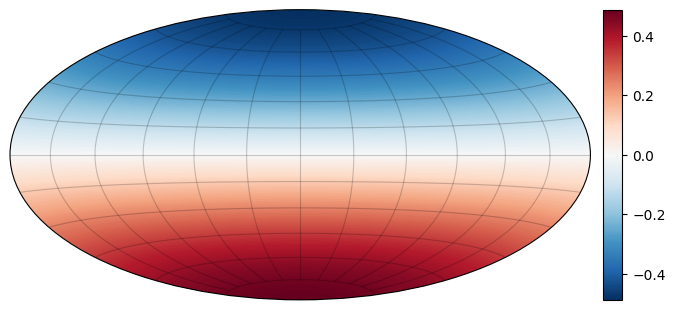

In [11]:
N = 4
omega0 = np.zeros(N**2)
omega0[2] =  1
W0 = qf.shr2mat(omega0, N=N)
qf.plot2(omega0, N = 512, colorbar=True)
plt.show()